# Problem Set #1

In [2]:
import numpy as np
import scipy.optimize as opt
from matplotlib import pyplot as plt
from collections import OrderedDict
import collections
import itertools
from itertools import islice
import scipy.interpolate as intpl
from numpy.polynomial import chebyshev
from scipy.interpolate import splev, splrep
from mpl_toolkits.mplot3d import Axes3D

## (1) Asset Market Equilibrium

### Part (a)

Budget Constrint:
Period 1: $$c_0^h = e_0^h - q_1 \theta_1^h + q_2 \theta_2^h$$
Period 2: For h = 1,2 and s = 1,2,3,4, $$c_s^h = e_s^h + \theta_1^h A_s^1 + \theta_2^h A_s^2$$

Bellman Equation:
$$v(c, s) = \max_{\{\theta_1, \theta_2\}} u(e_0^h - q_1 \theta_1^h + q_2 \theta_2^h) + \frac{1}{4}\sum_{s=1}^{4}v(e_s^h + \theta_1^h A_s^1 + \theta_2^h A_s^2)$$

FOC: 
\begin{align*}
[\theta_1]&: \quad -q_1u'(c_0^h) + \frac{1}{4} \sum_{s=1}^{4} \theta_1^h v'(c_s^h)=0\\
[\theta_2]&: \quad -q_2u'(c_0^h) + \frac{1}{4} \sum_{s=1}^{4} \theta_2^h v'(c_s^h)=0
\end{align*}

Since we have $u(c) = \dfrac{c^{1-\gamma}}{1-\gamma}$,

FOC: 
\begin{align*}
[\theta_1]&: \quad -q_1(e_0^h - q_1 \theta_1^h + q_2 \theta_2^h)^{-\gamma} = \frac{1}{4} \sum_{s=1}^{4} \theta_1^h (e_s^h + \theta_1^h A_s^1 + \theta_2^h A_s^2)^{-\gamma}\\
[\theta_2]&: \quad -q_2(e_0^h - q_1 \theta_1^h + q_2 \theta_2^h)^{-\gamma} = \frac{1}{4} \sum_{s=1}^{4} \theta_2^h (e_s^h + \theta_1^h A_s^1 + \theta_2^h A_s^2)^{-\gamma}
\end{align*}

Market Clearing Conditions:
$$c_0^1 + c_0^2 = e_0^1 + e_0^2$$
$$\theta_1^1 + \theta_1^2 = 0$$
$$\theta_2^1 + \theta_2^2 = 0$$

### Part (b) 

In [4]:
N = 500 # number of grid-points for the capital grid
k_low = 0.1 # lower bound for the capital grid
k_high = 1 # upper bound for capital grid
k_grid = np.linspace(k_low, k_high, N) #grid for capital

# Now we initialize the value function, I like to initialize it to zero.
V_init = np.zeros_like(k_grid)

In [5]:
def objective(params, args):
    
    theta_11, theta_12, theta_21, theta_22, p1, p2 = params
    gamma = args
    
    f11 = 1/4 * ( 1*(1+theta_11*1+theta_12*1)**(-gamma) + 1*(2+theta_11*1+theta_12*1)**(-gamma) \
                 +1*(1+theta_11*1+theta_12*1.5)**(-gamma) + 1*(2+theta_11*1+theta_12*1.5)**(-gamma) ) \
    - p1*(1 - p1*theta_11-p2*theta_12)**(-gamma) 
    f12 = 1/4 * ( 1*(1+theta_11*1+theta_12*1)**(-gamma)  + 1*(2+theta_11*1+theta_12*1)**(-gamma) \
                 + 1.5*(1+theta_11*1+theta_12*1.5)**(-gamma)  + 1.5*(2+theta_11*1+theta_12*1.5)**(-gamma)  ) \
    - p2*(1 - p1*theta_11-p2*theta_12)**(-gamma) 
    f21 = 1/4 * ( 1*(3+theta_21*1+theta_22*1)**(-gamma)  + 1*(1+theta_21*1+theta_22*1)**(-gamma)  \
                 + 1*(3+theta_21*1+theta_22*1.5)**(-gamma)  + 1*(1+theta_21*1+theta_22*1.5)**(-gamma) ) \
    - p1*(1 - p1*theta_21-p2*theta_22)**(-gamma) 
    f22 = 1/4 * ( 1*(3+theta_21*1+theta_22*1)**(-gamma)  + 1*(1+theta_21*1+theta_22*1)**(-gamma) \
                 + 1.5*(3+theta_21*1+theta_22*1.5)**(-gamma)  + 1.5*(1+theta_21*1+theta_22*1.5)**(-gamma) )\
    - p2*(1 - p1*theta_21-p2*theta_22)**(-gamma) 
    
    m1 = theta_11 + theta_21
    m2 = theta_12 + theta_22
    
    return np.array([f11,f12,f21,f22,m1,m2])

In [6]:
params_init = np.array([1.,-1.,-1.,1.,1.,1.])
gamma = 2
opt.fsolve(objective, params_init, args=gamma)

array([ 1.95406655e-02,  1.70069390e-11, -1.95406655e-02, -1.70069390e-11,
        5.89777656e-01,  7.37222070e-01])

## (2) Dynamic Programming (Tic-Tac-Toe)

Please refer to 'Tic-Tac-Toe.ipynb' for my solutions in the same directory.

## (3) Ramsey I

### (a) For 50 points

In [55]:
### init values
beta=0.9

N = 50 # number of grid-points for the capital grid
k_low = 0.01 # lower bound for the capital grid
k_high = 5 # upper bound for capital grid
k_grid = np.linspace(k_low, k_high, N) #grid for capital

# Now we initialize the value function:
V_init = np.column_stack([list(np.zeros_like(k_grid)), list(np.zeros_like(k_grid))])

In [32]:
def u(c):
    """
    input: 
    c: consumption
    
    output:
    utility received from consumption
    """
    return np.log(c)

In [33]:
def actionvalue_allchoices(k_index, s_index, V_old):
    """
    input:
    k_index: index so that k_grid[index] corresponds to value of capital this period (state)
    V_old: approximation to the value function. V_old[i] approximates V(k_grid[i]).
    
    output:
    action_value: value of all possible state-action pairs.
    """
    k = k_grid[k_index]
    
    action_value = np.zeros_like(k_grid)
    
    if s_index == 1:
        c = 0.9*k**0.3 + 0.3 * k - k_grid # consumption implied by policy k_next in state k
        
    if s_index == 2:
        c = 1.1*k**0.3 + 0.9 * k - k_grid # consumption implied by policy k_next in state k
    
    action_value[c <= 0] = -999999 # set value to -HUGE for negative consumption
    action_value[c > 0] = u(c[c > 0]) + beta * (0.5 * V_old[:,0][c > 0] + 0.5 * V_old[:,1][c > 0])
    
    return action_value

In [34]:
def vf_update(i, s_index, V_old):
    """
    input:
    i: index corresponding to the entry of the value-function vector which is updated
    V_old: value function vector from the previous iteration
    
    output:
    Vi_new: updated value for the value function vector at entry i.
    """
    Vi_new = np.max(actionvalue_allchoices(i, s_index, V_old))
    
    return Vi_new

In [35]:
def vf_update_iteration(V_old):
    """
    input: 
    V_old: array with current approximation of the value function
    
    output:
    V_new: updated approximation of the value function
    """
    V_new = np.zeros_like(V_old)

    for i in range(N):
        V_new[i, 0] = vf_update(i, 1, V_old)
        V_new[i, 1] = vf_update(i, 2, V_old)
    
    return V_new

In [36]:
def solve_value_func_iter():
    difference_list = []
    threshold = 1e-10
    max_iterations = 10000
    plot_interval = 50

    V = V_init.copy()

    for iteration in range(max_iterations):
        #print('Iteration: {}'.format(iteration + 1))

        ### begin TODO
        V_new = vf_update_iteration(V)
        difference = np.amax(abs(V_new - V))

        # TODO compute the maximum absolute difference between the old and new function

        difference_list.append(difference) # Nothing todo here

        V = V_new# TODO Copy the "new" value function to the "old"
        ### end TODO


        if difference < threshold:
            print('Converged after iteration {}'.format(iteration + 1))

            plt.figure()
            plt.plot(k_grid, V[:,0])
            plt.xlabel('k')
            plt.ylabel('V(k)')
            plt.title('Value function after convergence for Shock 1')
            plt.show();

            plt.figure()
            plt.plot(k_grid, V[:,1])
            plt.xlabel('k')
            plt.ylabel('V(k)')
            plt.title('Value function after convergence for Shock 2')
            plt.show();
            break
    
    return V

Converged after iteration 215


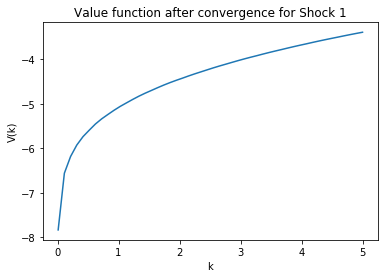

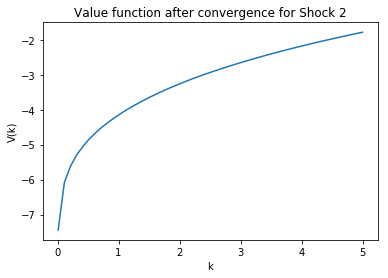

In [56]:
V = solve_value_func_iter()

In [57]:
def extract_policy(V, s_index):
    """
    input:
    V: value function array
    
    output:
    p: polcy function array
    """
    p_k = np.zeros_like(V)
    p_c = np.zeros_like(V)
    
    for i in range(len(V)): 
        p_k[i] = k_grid[np.argmax(actionvalue_allchoices(i, s_index, V))]
    
        if s_index == 1:
            p_c[i] = 0.9 * k_grid[i]**0.3 + 0.3 * k_grid[i] - p_k[i] # consumption implied by policy k_next in state k
        
        if s_index == 2:
            p_c[i] = 1.1 * k_grid[i]**0.3 + 0.9 * k_grid[i] - p_k[i] # consumption implied by policy k_next in state k
        
        
    return p_k, p_c

In [58]:
p_k_1, p_c_1 = extract_policy(V, 1)
p_k_2, p_c_2 = extract_policy(V, 2)

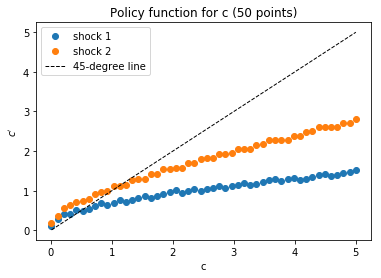

In [59]:
plt.close()
plt.figure()
plt.plot(k_grid, p_c_1[:, 0], 'o', label = 'shock 1')
plt.plot(k_grid, p_c_2[:, 0], 'o', label = 'shock 2')
plt.plot(k_grid, k_grid, color='black', linewidth=1, linestyle='--',
                 label='45-degree line')
plt.title('Policy function for c (50 points)')
plt.xlabel('c')
plt.ylabel(r"$c'$")
plt.legend(loc='upper left')
plt.show()

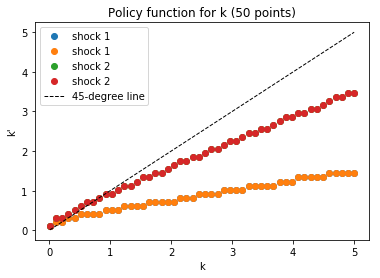

In [60]:
plt.figure()
plt.plot(k_grid, p_k_1, 'o', label = 'shock 1')
plt.plot(k_grid, p_k_2, 'o', label = 'shock 2')
plt.plot(k_grid, k_grid, color='black', linewidth=1, linestyle='--',
                 label='45-degree line')
plt.xlabel('k')
plt.ylabel("k'")
plt.title("Policy function for k (50 points)")
plt.legend(loc='upper left')
plt.show()

### (b) For 500 points

In [50]:
beta=0.9

N = 500 # number of grid-points for the capital grid
k_low = 0.01 # lower bound for the capital grid
k_high = 5 # upper bound for capital grid
k_grid = np.linspace(k_low, k_high, N) #grid for capital

# Now we initialize the value function:
V_init = np.column_stack([list(np.zeros_like(k_grid)), list(np.zeros_like(k_grid))])

Converged after iteration 215


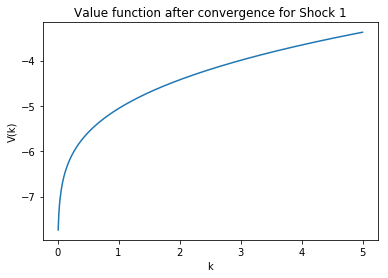

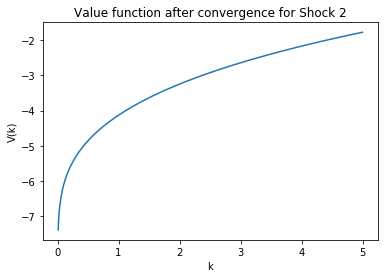

In [51]:
V = solve_value_func_iter()

In [52]:
p_k_1, p_c_1 = extract_policy(V, 1)
p_k_2, p_c_2 = extract_policy(V, 2)

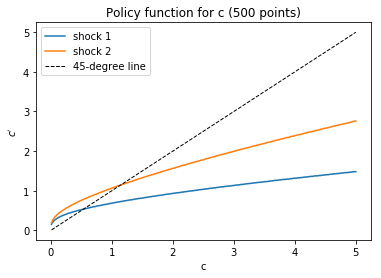

In [53]:
plt.plot(k_grid, p_c_1[:,0], label = 'shock 1')
plt.plot(k_grid, p_c_2[:,0], label = 'shock 2')
plt.plot(k_grid, k_grid, color='black', linewidth=1, linestyle='--',
                 label='45-degree line')
plt.title('Policy function for c (500 points)')
plt.xlabel('c')
plt.ylabel(r"$c'$")
plt.legend(loc='upper left')
plt.show()

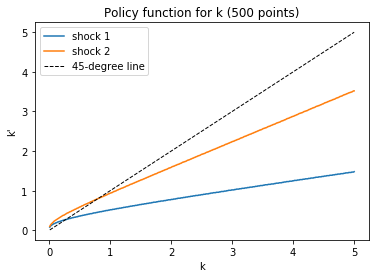

In [54]:
plt.figure()
plt.plot(k_grid, p_k_1[:,0], label = 'shock 1')
plt.plot(k_grid, p_k_2[:,0], label = 'shock 2')
plt.plot(k_grid, k_grid, color='black', linewidth=1, linestyle='--',
                 label='45-degree line')
plt.xlabel('k')
plt.ylabel("k'")
plt.title("Policy function for k (500 points)")
plt.legend(loc='upper left')
plt.show()

## (4) Stochastic Ramsey model, time iteration collocation

### (a) Discrete shocks

#### For v(c) = log(c)

In [3]:
N = 30 # number of grid-points for the capital grid
k_low = 0.01 # lower bound for the capital grid
k_high = 2 # upper bound for capital grid
k_grid = np.linspace(k_low, k_high, N) #grid for capital
beta = 0.9

In [4]:
def u_prime(c):
    return 1/c

In [5]:
def f_prime_1(k):
    return 0.27 * k**(-0.7) + 0.3

In [6]:
def f_prime_2(k):
    return 0.33 * k**(-0.7) + 0.9

In [7]:
def euler_equation(params, *args):
    k1 = params
    beta, s, k0, k_interp_s1, k_interp_s2 = args
    
    if s == 0:
        equ = beta * ( 0.5 * u_prime(0.9*k1**0.3 + 0.3*k1 - k_interp_s1(k1)) * f_prime_1(k1) \
        + 0.5 * u_prime(1.1*k1**0.3 + 0.9*k1 - k_interp_s2(k1)) * f_prime_2(k1) ) \
        - u_prime(0.9*k0**0.3 + 0.3*k0 - k1)
    
    if s == 1:
        equ = beta * ( 0.5 * u_prime(0.9*k1**0.3 + 0.3*k1 - k_interp_s1(k1)) * f_prime_1(k1) \
        + 0.5 * u_prime(1.1*k1**0.3 + 0.9*k1 - k_interp_s2(k1)) * f_prime_2(k1) ) \
        - u_prime(1.1*k0**0.3 + 0.9*k0 - k1)
    
    return equ

In [8]:
def get_chebyshev_zeros(ndegree, kbeg, kend):
    kgrid_cheby=np.zeros(ndegree+1)
    for i in range(np.size(kgrid_cheby)):
        kgrid_cheby[i]=0.5*(kend+kbeg)+0.5*(kend-kbeg)*np.cos(np.pi*((2*(i+1)-1.)/(2*np.size(kgrid_cheby))))
    kgrid_cheby.sort()
    
    return kgrid_cheby

In [9]:
def get_pol_coef(kgrid_cheby, k_plus0_init, k_plus1_init, ndegree):
    coeff0_init = chebyshev.chebfit(kgrid_cheby, k_plus0_init, ndegree)
    coeff1_init = chebyshev.chebfit(kgrid_cheby, k_plus1_init, ndegree)
    
    return coeff0_init, coeff1_init

In [12]:
def solve_policy_func(interp_type, ndegrees=0, plot=True):
    
    PF_iter = 0
    PF_maxiter = 200
    PF_dist = 10
    PF_mindist = 1e-8
    
    k_grid = np.linspace(k_low, k_high, N)
    
    if interp_type == 'polynomial':
        k_new = np.ones((ndegrees+1,2)) * k_low
    else:
        k_new = np.ones((N,2)) * k_low

    while (PF_iter < PF_maxiter) and (PF_dist > PF_mindist):

        PF_iter += 1
        k_init = k_new.copy()

        if interp_type == 'polynomial':
            #kgrid_cheby = get_chebyshev_zeros(5, k_low, k_high)
            k_grid = get_chebyshev_zeros(ndegrees, k_low, k_high)
            coeff0_init, coeff1_init = get_pol_coef(k_grid, k_init[:, 0], k_init[:, 1], ndegrees)
            
            k_interp_s1 = lambda x: chebyshev.chebval(x, coeff0_init)
            k_interp_s2 = lambda x: chebyshev.chebval(x, coeff1_init)
            
        else:            
            k_interp_s1 = intpl.interp1d(k_grid, k_init[:, 0], kind=interp_type, \
                                           fill_value='extrapolate')
            k_interp_s2 = intpl.interp1d(k_grid, k_init[:, 1], kind=interp_type, \
                                           fill_value='extrapolate')
        
        if interp_type == 'polynomial':
            num_grid = ndegrees + 1
        else: 
            num_grid = N 
            
        for k_ind in range(num_grid):
            for s in range(2):

                k = k_grid[k_ind]
                params_init = k_low # guess for k1
                k_args = (beta, s, k, k_interp_s1, k_interp_s2)

                k1, infodict, ier, mesg = opt.fsolve(euler_equation, params_init, args=k_args, full_output = True)
                if not ier == 1:
                    print(mesg)
                    print(infodict)
                assert ier == 1, 'Solver not succesfull'
                k_new[k_ind, s] = k1

        PF_dist = np.amax(abs(k_init - k_new))
        # print('PF_iter=', PF_iter, ', PF_dist=', PF_dist) 
    
    print('Converged after iteration {}'.format(PF_iter))
    
    if plot == True:
        
        plt.plot(k_grid, k_new[:,0], label=r'Policy function k (shock 1)')
        plt.plot(k_grid, k_new[:,1], label=r'Policy function k (shock 2)')
        plt.plot(k_grid, k_grid, color='black', linewidth=1, linestyle='--',
                 label='45-degree line')
        plt.title('Policy Function for Investment' + ' (' + interp_type + ')')
        plt.xlabel('$k$')
        plt.ylabel("$k'$")
        plt.legend()

Converged after iteration 26


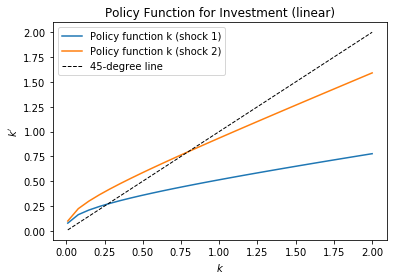

In [13]:
solve_policy_func('linear')

Converged after iteration 27


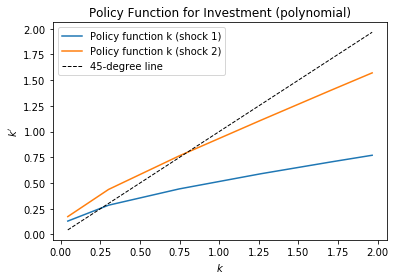

In [14]:
solve_policy_func('polynomial', ndegrees=5)

Converged after iteration 26


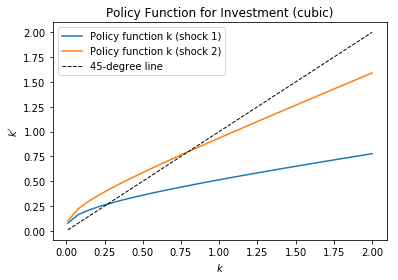

In [15]:
solve_policy_func('cubic')

#### For v(c) = $-c^{-4}$ 

In [16]:
N = 30 # number of grid-points for the capital grid
k_low = 0.01 # lower bound for the capital grid
k_high = 8 # upper bound for capital grid
k_grid = np.linspace(k_low, k_high, N) #grid for capital
beta = 0.999

In [17]:
def u_prime(c):
    return 4*c**-5

Converged after iteration 67


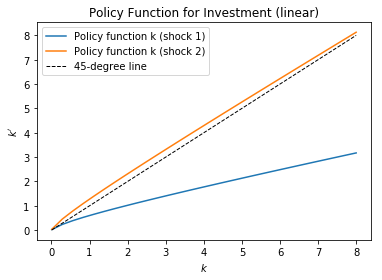

In [18]:
solve_policy_func('linear')

Converged after iteration 65


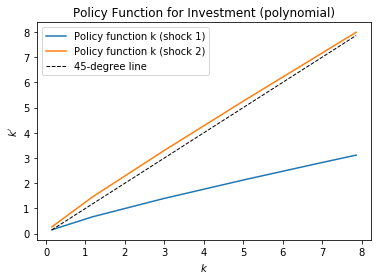

In [19]:
solve_policy_func('polynomial', ndegrees=5)

Converged after iteration 69


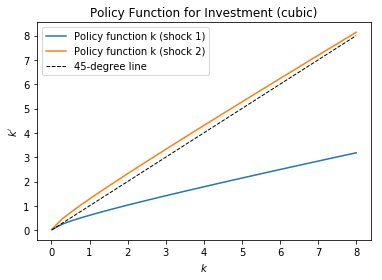

In [20]:
solve_policy_func('cubic')

### (b) AR(1) shocks

In [21]:
N_k = 10 # number of grid-points for the capital grid
k_low = 0.01 # lower bound for the capital grid
k_high = 6 # upper bound for capital grid
k_grid = np.linspace(k_low, k_high, N_k) #grid for capital

N_A = 10
A_low = -0.01 * 3
A_high = 0.01 * 3
A_grid = np.linspace(A_low, A_high, N_A)

In [22]:
def u_prime(c):
    return 1/c

In [23]:
def f(k, A):
    return np.exp(A) * k ** 0.3 + 0.5 * k

In [24]:
def f_prime(k, A):
    return 0.3 * np.exp(A) * k ** (-0.7) + 0.5

In [25]:
def mid_int(g, a, b, N):
    
    int_sum = 0
    for i in range(N):
        x_i = a + (2*i+1)*(b-a)/(2*N)
        int_sum += g(x_i)
    mid_int = (b-a)/N * int_sum
    return mid_int

In [26]:
def normal_pdf(A_prime, mu, sigma):
    return 1 / np.sqrt(2*np.pi*sigma**2) * np.exp(-(A_prime-mu)/(2*sigma**2))

In [27]:
def euler_equation(params, args):
    k1 = params
    beta, k0, A, k_interp = args
    integrand = lambda A_prime: u_prime(f(k1, A_prime)-k_interp(k1, A_prime)) * f_prime(k1, A_prime)*normal_pdf(A_prime, 0.9*A, 0.1)
    integral = mid_int(integrand, \
            A_low, A_high, 20)
    equ = beta * integral \
            - u_prime(f(k0, A) - k1)
    
    return equ

In [28]:
def solve_policy_func(interp_type, plot=True):
    
    PF_iter = 0
    PF_maxiter = 200
    PF_dist = 10
    PF_mindist = 1e-8

    grid_new = np.ones((N_k, N_A)) * k_low
    beta = 0.9

    while (PF_iter < PF_maxiter) and (PF_dist > PF_mindist):

        PF_iter += 1
        grid_init = grid_new.copy()
        
        grid_interp = intpl.interp2d(k_grid, A_grid, grid_init, kind=interp_type)
        
        print(grid_interp)
        for k_ind in range(N_k):
            for A_ind in range(N_A):
            
                k = k_grid[k_ind]
                A = A_grid[A_ind]
                params_init = k_low # guess for k1
                
                #lambda kprime : euler_equation(kprime, beta, k, A, grid_interp)
                args = np.array([beta, k, A, grid_interp])
                
                #k1, infodict, ier, mesg = opt.fsolve(local_euler, params_init, full_output = True)
                k1, infodict, ier, mesg = opt.fsolve(euler_equation, params_init, args, full_output = True)
                if not ier == 1:
                    print(mesg)
                    print(infodict)
                assert ier == 1, 'Solver not succesfull'
                grid_new[k_ind, A_ind] = k1

        PF_dist = np.amax(abs(grid_init - grid_new))
        #print('PF_iter=', PF_iter, ', PF_dist=', PF_dist) 
    
    print('Converged after iteration {}'.format(PF_iter))
    #return grid_new
    
    if plot == True:
        plt.imshow(grid_new)
        plt.colorbar()
        plt.xlabel('A')
        plt.ylabel('k')
        plt.show()
        
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca(projection='3d')
        X, Y = np.meshgrid(A_grid, k_grid)
        surf = ax.plot_wireframe(X, Y, grid_new)
        ax.set_xlabel('A')
        ax.set_ylabel('k')

Converged after iteration 11


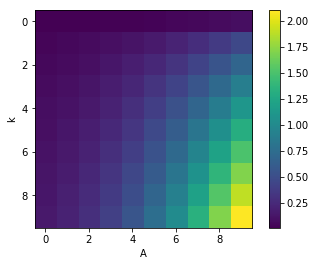

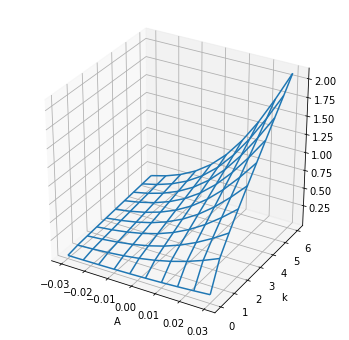

In [29]:
solve_policy_func('linear', plot=True)

Converged after iteration 11


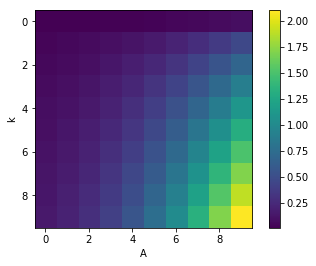

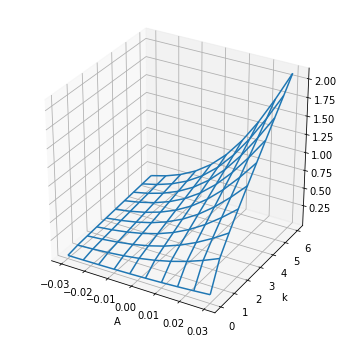

In [30]:
solve_policy_func('cubic', plot=True)